This notebook is a simple example of how to use the `AnnubesEnv` class to create a custom environment and use it to train a reinforcement learning agent with `stable_baselines3`.

## `AnnubesEnv` environment

Let's create an environment, check it works and visualize it.


In [ ]:
import neurogym as ngym
from neurogym.envs.annubes import AnnubesEnv
from stable_baselines3.common.env_checker import check_env

env = AnnubesEnv()

# check the custom environment and output additional warnings (if any)
check_env(env)

# check the environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

print(env.timing)
print("----------------")
print(env.observation_space)
print(env.observation_space.name)
print("----------------")
print(env.action_space)
print(env.action_space.name)

{'fixation': 500, 'stimulus': 1000, 'iti': 0}
----------------
Box(0.0, 1.0, (4,), float32)
{'fixation': 0, 'start': 1, 'v': 2, 'a': 3}
----------------
Discrete(2)
{'fixation': 0, 'choice': [1]}


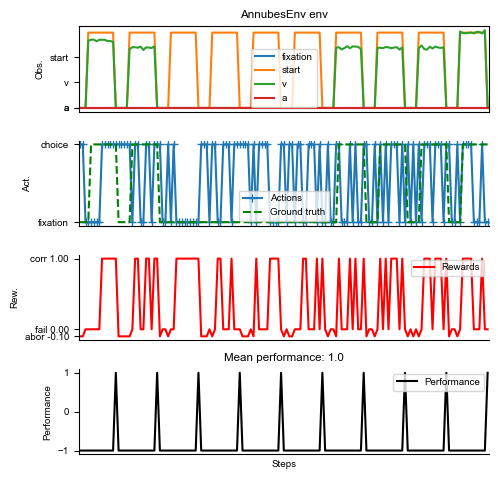

In [2]:
fig = ngym.utils.plot_env(
    env,
    ob_traces=["fixation", "start", "v", "a"],
    num_trials=10
)

## Training `AnnubesEnv`

### 1. Regular training

We can train `AnnubesEnv` using one of the models defined in `stable_baselines3`, for example [`A2C`](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html).


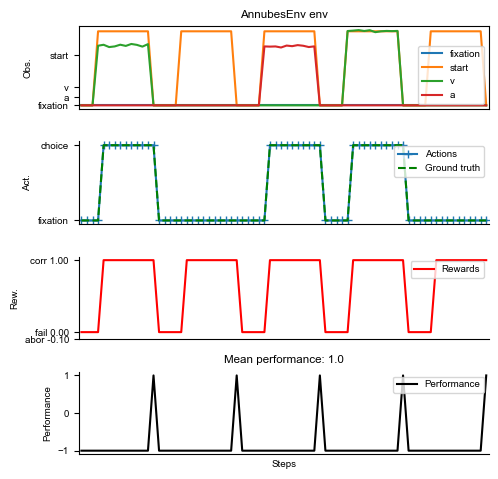

In [19]:
import warnings

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

warnings.filterwarnings("default")

# train agent
env = AnnubesEnv()
env_vec = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env_vec, verbose=0)
model.learn(total_timesteps=20000, log_interval=1000)
env_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env, num_trials=5, ob_traces=["fixation", "start", "v", "a"], model=model)

### 2. Sequential training

We can also train `AnnubesEnv` using a sequential training approach. This is useful when we want to train the agent in multiple stages, each with a different environment configuration. This can be useful for:

- **Curriculum learning**: Gradually increase the difficulty of the environments. Start with simpler tasks and progressively move to more complex ones, allowing the agent to build on its previous experiences.

- **Domain randomization**: Vary the environment dynamics (e.g., physics, obstacles) during training to improve the agent's robustness to changes in the environment.

- **Transfer learning**: If you have access to different agents or architectures, you can use transfer learning techniques to fine-tune the model on a new environment.


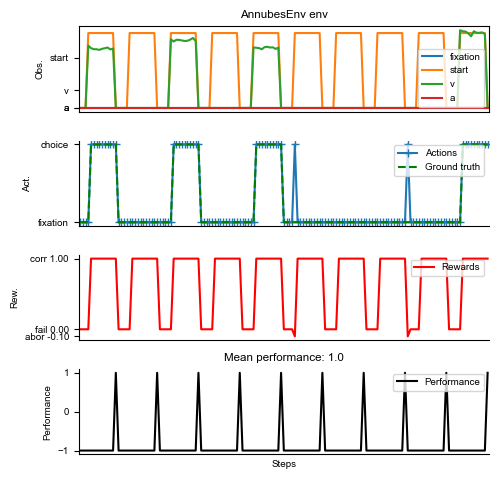

In [20]:
# train the agent with the first version of the environment
env1 = AnnubesEnv({"v": 1, "a": 0})
env1_vec = DummyVecEnv([lambda: env1])
model = A2C("MlpPolicy", env1_vec, verbose=0)
model.learn(total_timesteps=10000)
env1_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env1, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

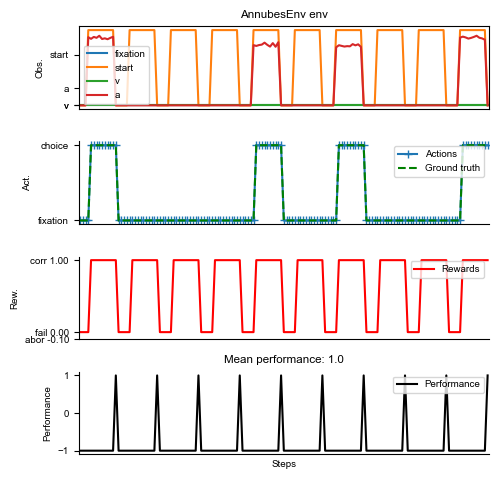

In [21]:
# switch to the second environment and continue training
env2 = AnnubesEnv({"v": 0, "a": 1})
env2_vec = DummyVecEnv([lambda: env2])
model.set_env(env2_vec)
model.learn(total_timesteps=10000)
env2_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env2, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

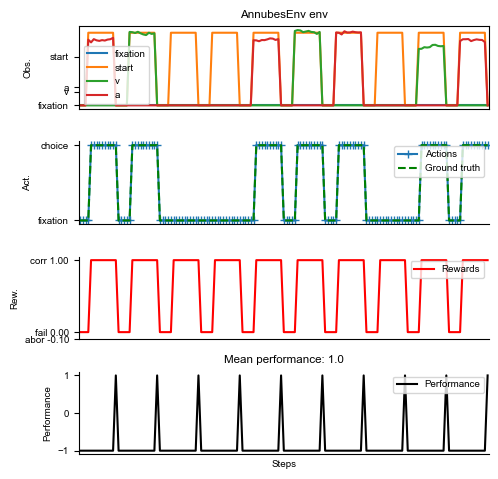

In [22]:
# Switch to the third environment and finish training
env3 = AnnubesEnv({"v": 0.5, "a": 0.5})
env3_vec = DummyVecEnv([lambda: env3])
model.set_env(env3_vec)
model.learn(total_timesteps=20000)
env3_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env3, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

In [ ]:
# Save the final model after all training
model.save("final_model")